# Introduction to the pycox package


In this notebook we introduce the use of `pycox` through an example dataset.
We illustrate the procedure with the `LogisticHazard` method ([paper_link](https://arxiv.org/abs/1910.06724)), but we this can easily be replaced by for example `PMF`, `MTLR` or `DeepHitSingle`.

In the following we will:

- Load the METABRIC survival dataset.
- Process the event labels so the they work with our methods.
- Create a [PyTorch](https://pytorch.org) neural network.
- Fit the model.
- Evaluate the predictive performance using the concordance, Brier score, and negative binomial log-likelihood.

While some knowledge of the [PyTorch](https://pytorch.org) framework is preferable, it is not required for the use of simple neural networks.
For building more advanced network architectures, however, we would recommend looking at [the PyTorch tutorials](https://pytorch.org/tutorials/).

## Imports

You need `sklearn-pandas` which can be installed by uncommenting the following block

In [34]:
# ! pip install sklearn-pandas

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

`pycox` is built on top of [PyTorch](https://pytorch.org) and [torchtuples](https://github.com/havakv/torchtuples), where the latter is just a simple way of training neural nets with less boilerplate code.

In [36]:
import torch # For building the networks 
import torchtuples as tt # Some useful functions

We import the `metabric` dataset, the `LogisticHazard` method ([paper_link](https://arxiv.org/abs/1910.06724)) also known as [Nnet-survival](https://peerj.com/articles/6257/), and `EvalSurv` which simplifies the evaluation procedure at the end.

You can alternatively replace `LogisticHazard` with, for example, `PMF` or `DeepHitSingle`, which should both work in this notebook.

In [37]:
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [38]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [39]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [40]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [41]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [42]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
For most of them the `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

The `LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [43]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [44]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

The `labtrans.cuts` contains the discretization grid. This will later be used to obtain the right time-scale for survival predictions.

In [45]:
labtrans.cuts

array([  0.      ,  39.466667,  78.933334, 118.4     , 157.86667 ,
       197.33334 , 236.8     , 276.26666 , 315.73334 , 355.2     ],
      dtype=float32)

Now, `y_train` is a tuple with the indices of the discretized times, in addition to event indicators.

In [46]:
y_train

(array([2, 3, 6, ..., 1, 5, 3], dtype=int64),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

In [47]:
labtrans.cuts[y_train[0]]

array([ 78.933334, 118.4     , 236.8     , ...,  39.466667, 197.33334 ,
       118.4     ], dtype=float32)

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `out_features` output nodes.
We also have batch normalization and dropout between the layers.

In [48]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [49]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, or use one from `tt.optim`.
The latter is built on top of the `torch` optimizers, but with some added functionality (such as not requiring `net.parameters()` as input and the `model.lr_finder` for finding suitable learning rates).
We will here use the `Adam` optimizer with learning rate 0.01.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

The `LogisticHazard` can also take the argument `device` which can be use to choose between running on the CPU and GPU. The default behavior is to run on a GPU if it is available, and CPU if not.
See `?LogisticHazard` for details.

In [50]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

Next, we set the `batch_size` and the number of training `epochs`.

We also include the `EarlyStopping` callback to stop training when the validation loss stops improving.

In [51]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

We can now train the network and the `log` object keeps track of the training progress.

In [52]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9263,	val_loss: 2.7659
1:	[0s / 0s],		train_loss: 2.6603,	val_loss: 2.5461
2:	[0s / 0s],		train_loss: 2.3791,	val_loss: 2.2354
3:	[0s / 0s],		train_loss: 2.0756,	val_loss: 1.9005
4:	[0s / 0s],		train_loss: 1.7898,	val_loss: 1.5965
5:	[0s / 0s],		train_loss: 1.5691,	val_loss: 1.4399
6:	[0s / 0s],		train_loss: 1.4533,	val_loss: 1.3834
7:	[0s / 0s],		train_loss: 1.4080,	val_loss: 1.3732
8:	[0s / 0s],		train_loss: 1.3977,	val_loss: 1.3749
9:	[0s / 0s],		train_loss: 1.3683,	val_loss: 1.3710
10:	[0s / 0s],		train_loss: 1.3406,	val_loss: 1.3672
11:	[0s / 0s],		train_loss: 1.3476,	val_loss: 1.3632
12:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.3599
13:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.3536
14:	[0s / 0s],		train_loss: 1.3253,	val_loss: 1.3544
15:	[0s / 0s],		train_loss: 1.3170,	val_loss: 1.3566
16:	[0s / 0s],		train_loss: 1.3101,	val_loss: 1.3618
17:	[0s / 0s],		train_loss: 1.3191,	val_loss: 1.3643
18:	[0s / 0s],		train_loss: 1.2992,	val_loss: 1.3638
19:

c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwa

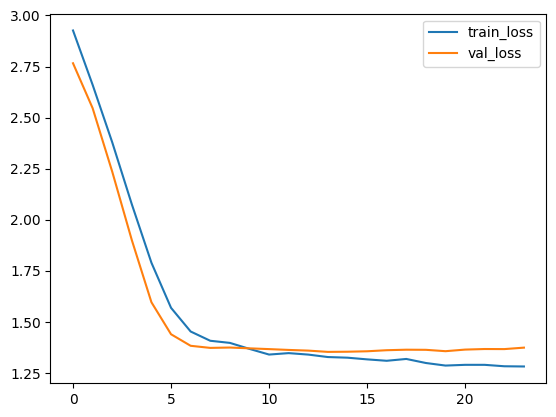

In [53]:
_ = log.plot()

After termination, the `EarlyStopping` callback loads the best performing model (in terms of validation loss).
We can verify this by comparing the minimum validation loss to the validation score of the trained `model`.

In [54]:
log.to_pandas().val_loss.min()

1.353621244430542

In [55]:
model.score_in_batches(val)

{'loss': 1.353621244430542}

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [56]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

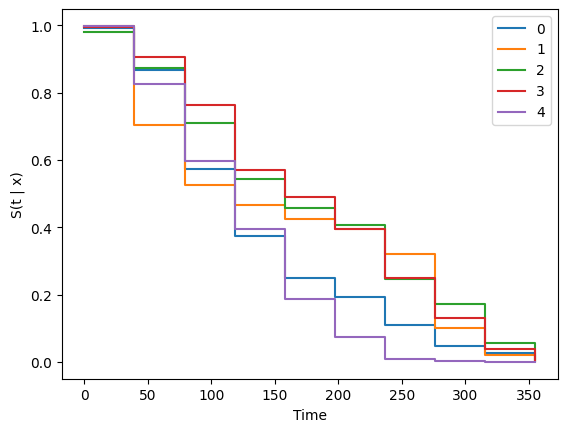

In [57]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to [interpolate the survival estimates](https://arxiv.org/abs/1910.06724).
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [58]:
surv = model.interpolate(10).predict_surv_df(x_test)

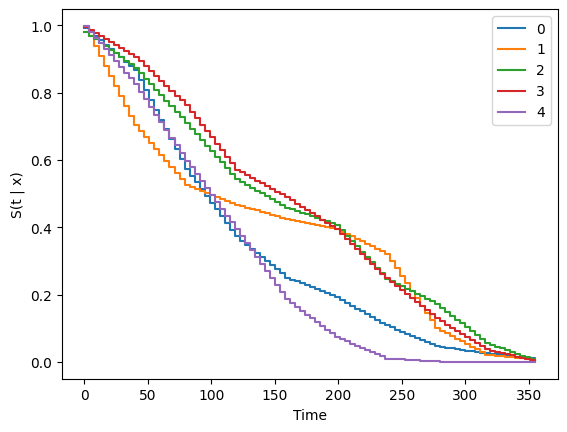

In [59]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [60]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [61]:
ev.concordance_td('antolini')

0.6476323710203908

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

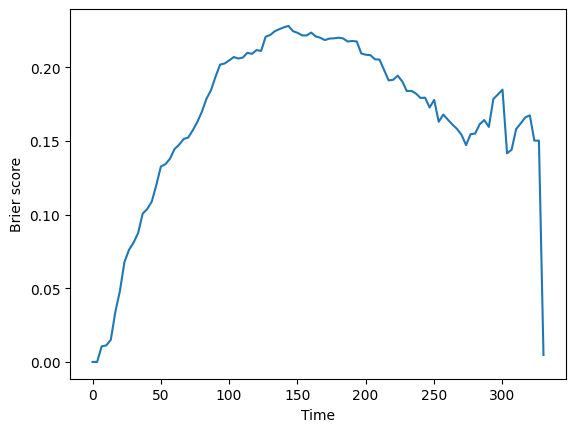

In [62]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

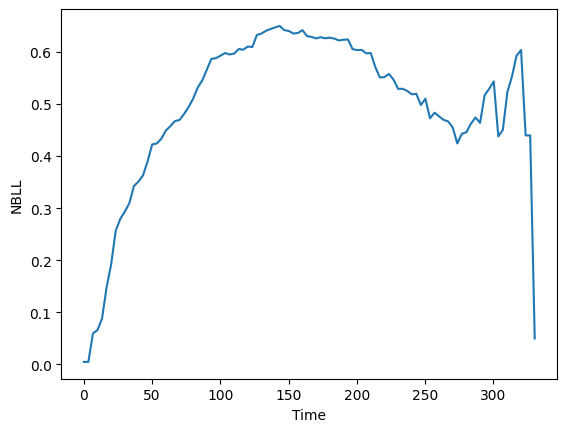

In [63]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [64]:
ev.integrated_brier_score(time_grid) 

0.16773813911662255

In [65]:
ev.integrated_nbll(time_grid) 

0.49806790364211445

# Next

You can now look at other examples of survival methods in the [examples folder](https://nbviewer.jupyter.org/github/havakv/pycox/tree/master/examples).
Or, alternatively take a look at

- the more advanced training procedures in the notebook [02_introduction.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/02_introduction.ipynb).
- other network architectures that combine autoencoders and survival networks in the notebook [03_network_architectures.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/03_network_architectures.ipynb).
- working with DataLoaders and convolutional networks in the notebook [04_mnist_dataloaders_cnn.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb).